In [10]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TODO

- [x] TASK: Quantify overhead of timing mode (maybe need to switch to full config) (44% overhead on small config wall clock time, ) 
- [ ] TASK: 64-core runs

# Notes

Overhead = 24.28 versus 16.9 (44%) wall clock, similar at thread level

That's significant enough we probably need to come up with a different path here, but overhead may be different elsewhere...also, that difference in timeing (full app) doesn't adjust enough what we are seeing in difference in perf.

In [75]:
16.9 / 24.28

0.6960461285008236

In [18]:
# Load data from csvs

config_dir = "~/mywork/data/"
exp_dir = "~/mywork/data/lqcd-fprop/"

timepd = pd.read_csv(exp_dir+"roofline_time.csv")
stats = pd.read_csv(exp_dir+"roofline.csv")
machine = pd.read_csv(config_dir+"machines.csv")



In [36]:
# Roofline baseline plot

def roofline_plot(name, bw, flops, core_num):
    intensity = np.logspace(-2, 4, 1024)  # 0.01 to 512 FLOP/byte
    plt.figure(figsize=(10, 6))
    crosspoint_bw = 64*1000*1000*1000
    mem_bw = min(list(bw.values()))
    mem_bw = min(mem_bw, crosspoint_bw*core_num)
    
    for label, max_flops in flops.items():
        performance = np.minimum(max_flops * core_num, mem_bw * intensity) / 1e9  # Convert to GFLOP/s
        plt.loglog(intensity, performance, label=label)

    maxflops = max(flops.values()) * core_num
    for label, bw in bw.items():
#        if label == "Mem":
#            continue
        if label == "L1" or label == "L2" or label=="SLC":
            bw = bw * core_num
            
        performance = np.minimum(maxflops, bw * intensity) / 1e9  # Convert to GFLOP/s
        plt.loglog(intensity, performance, label=label)

    # Format x-axis labels as non-scientific notation
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.xlabel('Operational Intensity (FLOP/byte)')
    plt.ylabel('Performance (GFLOP/s)')  # Change label to GFLOP/s
    plt.grid(True, which='both', ls=':')
    plt.title(f'Roofline Model: {name} ({core_num} cores)')

    return plt

def roofline_finish(name, plt, fname=""):
    plt.legend(loc="center right")
    if fname != "":
        plt.savefig(f"{fname}.svg", format="svg")
        
    plt.show()

In [54]:
bw = {
    'L1': machine['L1bw'][0]/64,
    'L2': machine['L2bw'][0]/64,
    "SLC": machine['SLCbw'][0]/64,
    'Mem': machine['membw'][0],
} 

flops = {
    #'uarch': machine['idealflops64'][0],
    'neon': machine['neonflops64'][0]/64,
    'sve': machine['neonflops64'][0]/64,
}

In [76]:
# this calculates the sum of the parts
# NOTES: this seems wrong, we need to go back and compare to what we do elsewhere
time = timepd['elapsed'].max()
# EXPERMINET: adjust time based on expected overhead
time = time * .7
total_flops = stats['flops'].sum()
total_bw =stats['read_bytes'].sum()
ai = stats['flops'] / stats['read_bytes']
gfs = stats['flops'] / time / 1000 / 1000 / 1000
total_ai = total_flops/total_bw
gflops = total_flops/time/1000/1000/1000
bws = total_bw/time/1000/1000/1000

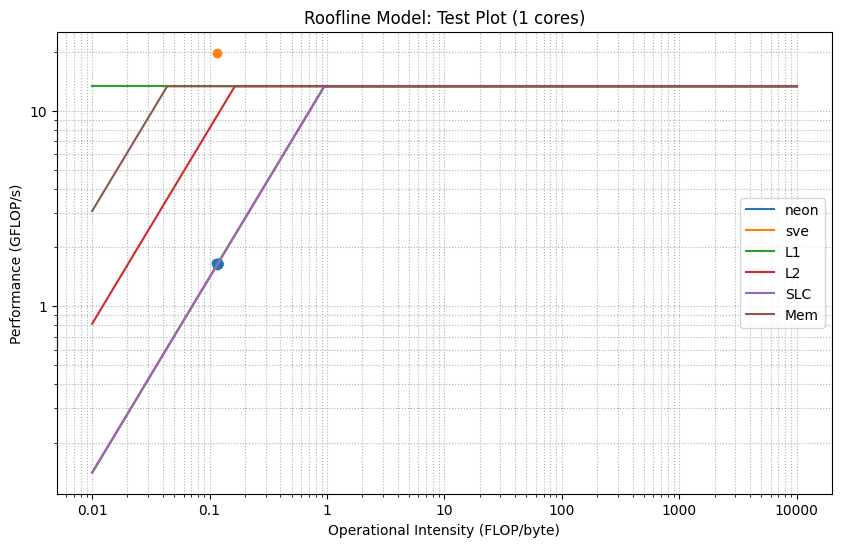

In [77]:
# setup machine ploot
plt = roofline_plot("Test Plot", bw, flops, 1)
plt.legend(loc="center right")


plt.scatter(ai,gfs)
plt.scatter(total_ai,gflops)
plt.show()

# Notes

Algorithmic intensity looks off still (x86 is hovering just above 0.1) and measured PMU arm version is much higher.
GFLOPs on the other hand doesn't look crazy -- but we really need to run the 64-core version to have a comparison (this is gathered on a 12 core, which shouldn't change things dramatically, but we are also potentially running a different config)

This is the total plot, but what we really need is the scatter plot of all the points (maybe) -- although the delta on the per-core scatter isn't crazy different so maybe who cares.

ALSO: the combinatorial scatter isn't going to work, this chart is scaled for 64-core, but the single core number needs to be calibrated on a single core chart.

We need to go back over our numbers, I'm not convinced of any of this being correct at the moment.

We probably should go with a calibration run first.

Actually the big number we aren't taking into consideration is the impact of instrumenting the code in this way.
We need to get a total runtime with and without instrumentation (in timing mode) - that'll give us a better absolute delta than this shit.
If that number is dramatically off we need to rethink the instrumentation (ie. go to some sort of breakpoint methodology)


Without it we can get total flop and memory bandwidth numbers, but then we'll need to extract timing elsewhere (PMUs?)
The massive difference in algorithmic intensity isn't explained by this though.

If we switch to just lookin at read_bytes then the number looks much closer to the intel number (maybe exactly the intel number?)

Also - just realized in the report that the intel number is the same for 1 or 64 cores...hmmm....

# Scratch Notes

- original roofline plot just setup the basics, so that's largely going to be the same although I guess we'd want to load machine configs from a file


# Backup

Everything below here is just scratch playing with stuff, but keeping for now as a reference

In [21]:

import pandas as pd

df = pd.read_csv('~/mywork/fs_benchmarks/LQCD-DWF-HMC/submit_roofline_csv/bridge.elf_alt_qxs2024-03-14_23:00:44/roofline.csv')
time = 22.794503
total_flops = df['flops'].sum()
total_bw = df['bytes'].sum()
total_ai = total_flops/total_bw
gflops = total_flops/time/1000/1000/1000
bw = total_bw/time/1000/1000/1000

total_flops



528888842654

In [64]:
stats['memory_histogram'][0]

'{24783494 245145 2771901743 660279594 489398262 238514373 0 0 }'

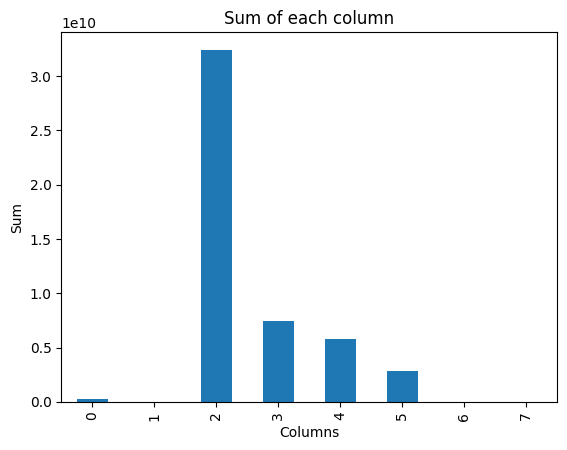

In [68]:
# parse histogram
s = stats['memory_histogram'][0]
# Remove the curly braces and split the string into a list
s = s.replace('{', '').replace('}', '')
list_of_strings = s.split()
list_of_numbers = [float(i) if '.' in i else int(i) for i in list_of_strings]

a_s = stats['memory_histogram']
# Convert each string in the array to a list of numbers
array_of_lists = []
for s in a_s:
    s = s.replace('{', '').replace('}', '')
    list_of_strings = s.split()
    list_of_numbers = [float(i) if '.' in i else int(i) for i in list_of_strings]
    array_of_lists.append(list_of_numbers)

mem_hist = pd.DataFrame(array_of_lists)
column_sums = mem_hist.sum()
# Create a bar chart
import matplotlib.pyplot as plt
column_sums.plot(kind='bar')

plt.xlabel('Columns')
plt.ylabel('Sum')
plt.title('Sum of each column')
plt.show()

In [69]:
((column_sums[2])+(column_sums[3]*32)+(column_sums[4]*96)+(column_sums[5]*224))


1460720946978

- [ ] TASK: This needs to be generalized to sum across threads (or report different bars for different threads?)
- [ ] TASK: We need to fix legend
- [ ] TASK: We need an option to make the report based on total bytes not accesses
- [ ] TASK: We also probably need to fix this to tease out read vs write behavior
